In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn

data_path = './../../data/processed/'

import json
vardict = json.load(open("variables.json"))
def add_entry(vardict, name, element):
    vardict[name]= element
    return vardict

# vardict = dict() dont run!, only if we need to clean the variables from scratch
# args = ['variable2', x.format()]
# res = add_entry(vardict, *args)

varnames_list = []

import numpy as np

# Total size distribution

In [2]:
col = 'ID'
df = pd.read_csv(data_path + col.replace(' ', '_')+'_YM.csv')
# df['date'] = pd.to_datetime(df.MONTH.astype(str) + '/' + df.YEAR.astype(str), format = '%m/%Y')
df['date'] = pd.DatetimeIndex(pd.to_datetime(12*(df.YEAR - 1997) + df.MONTH, unit='M', origin=pd.Timestamp('1996-12-15'))).round('D')
# df['date'] = pd.DatetimeIndex(pd.to_datetime(12*(df.YEAR - 1997) + df.MONTH, unit='M', origin=pd.Timestamp('1996-12-15'))).round('D')


In [3]:
fs_df = df.groupby(['ID','IMPORT','YEAR'])['VART'].sum().reset_index()

## Fit parabola

In [4]:
from numpy import log10, inf, nan
fs_df['log_VART'] = log10(fs_df['VART'])

i = 0
fs_df_slice = fs_df.loc[fs_df.IMPORT == i].replace(-inf, nan).dropna()
fs_df_slice['bin'], bins_x = pd.cut(fs_df_slice['log_VART'], 90, retbins=True)
bin_width = pd.Series(bins_x).diff().median()

fs_ct_val = fs_df_slice.groupby('bin').agg({'ID': 'count', 'VART': sum}).rename(columns = {'ID': 'counts', 'VART': 'value'})

fs_ct_val/=fs_ct_val.sum()
fs_ct_PDF = fs_ct_val/bin_width

fs_ct_PDF['log_VART'] = (bins_x[:-1] + bins_x[1:])/2.

fit_data = fs_ct_PDF.loc[np.array([b.mid for b in fs_ct_PDF.index]) > 3]

# attention, this is natural log, but better for getting the exponent of the lognormal
fit_data[['counts', 'value']] = np.log(fit_data[['counts', 'value']]).add_suffix('_log')


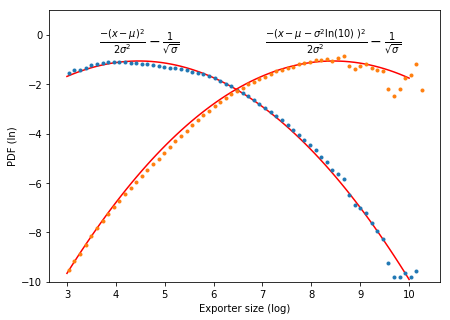

In [25]:
fig, ax = plt.subplots(1, figsize = (7, 5))

## COUNTS
x = fit_data.log_VART
y = fit_data.counts
z = np.polyfit(x, y, 2)
p = np.poly1d(z)

xp = np.linspace(3, 10, 70)
ax.plot(xp, p(xp), '-', c = 'r')
ax.plot(x, y, '.', c = '#1f77b4')

sigma = 1/np.sqrt(-2*z[0])
mu = -z[1]/(2*z[0])

# cnt, bns = np.histogram(np.random.normal(mu, sigma, 1000000), x)
# cnt = cnt/cnt.sum()
# plt.plot(x[:-1] + .115/2, np.log(cnt) + 2.2)

# VALUE
#fit
zval = np.polyfit(x + (sigma**2)*np.log(10), y, 2)
poly_val = np.poly1d(zval)
# plt.plot(x[:-1] + .115/2, np.log(cnt) + 2.2)
ax.plot(xp, poly_val(xp), '-', c = 'r')

#points
y2 = fit_data.value
plt.plot(x, y2, '.', c = '#ff7f0e')
cnt, bns = np.histogram(np.random.normal(mu + (sigma**2)*np.log(10), sigma, 1000000), x)
cnt = cnt/cnt.sum()


# label='%5.3f x + %5.3f' % tuple(popt)
# ddd

ax.annotate(r'$ \frac{{-(x - \mu)} ^{2}}{2 {\sigma}^{2}}  - \frac{1}{\sqrt{\sigma}}$' % mu, xy=(mu, -.5), ha="center", fontsize=14)
ax.annotate(r'$ \frac{{-(x - \mu - {\sigma}^{2} \ln(10)\ )} ^{2}}{2 {\sigma}^{2}} - \frac{1}{\sqrt{\sigma}}$', 
            xy=(mu + (sigma**2)*np.log(10), -.5), ha="center", fontsize=14)

ax.set_ylim(-10, 1)
ax.set_xlabel('Exporter size (log)')
ax.set_ylabel('PDF (ln)')
plt.savefig('./../../../thesis_writing/figures/parabolas_fit.png', dpi = 400)
plt.show()

In [15]:
y2.max() / (-1/np.sqrt(sigma))

1.0100041546991176

### Save fitted params

In [8]:
varnames_list = []
sigma = 1/np.sqrt(-2*z[0])
mu = -z[1]/(2*z[0])
muval = mu + (sigma**2)*np.log(10)

varnames_list += [['lognormal_fit_mu', "{:.2f}".format(mu)]] 
varnames_list += [['lognormal_fit_muval', "{:.2f}".format(muval)]] 
varnames_list += [['lognormal_fit_sigma', "{:.2f}".format(sigma)]] 

for name in varnames_list:
    res = add_entry(vardict, *name)

f = open("variables.json","w")
f.write(json.dumps(res))
f.close()

varnames_list

[['lognormal_fit_mu', '4.47'],
 ['lognormal_fit_muval', '8.45'],
 ['lognormal_fit_sigma', '1.31']]

# Quantiles

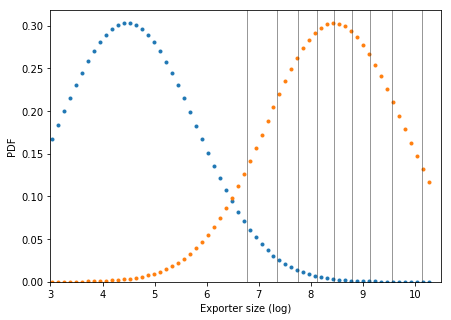

In [26]:
from scipy.special import erfinv

# Quantiles of the value distribution
qx = []
cum_cnt = []
for q in np.arange(0.1, 1.1, .1):
    _x = sigma*np.sqrt(2)*erfinv(2*q - 1) + mu + (sigma**2)*np.log(10)
    qx += [_x]
    cum_cnt += [.5*(np.erf((_x - mu)/(sigma*np.sqrt(2))) + 1)]
#     cum_cnt += [.5*(np.erf( erfinv(2*q - 1) + sigma*np.log(10)/np.sqrt(2) ) + 1)]

# gaussian function for plotting
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))/(np.sqrt(2*np.pi*sig**2))

# PLOT
fig, ax = plt.subplots(1, figsize = (7, 5))
x = fit_data.log_VART
ax.plot(x, gaussian(x, mu, sigma), '.', c = '#1f77b4')
ax.plot(x, gaussian(x, mu + (sigma**2)*np.log(10), sigma), '.', c = '#ff7f0e')
# ax.annotate(r'$ \frac{{-(x - \mu)} ^{2}}{2 {\sigma}^{2}}  + c$' % mu, xy=(mu, -.5), ha="center", fontsize=14)

# Quantiles as vertical lines
for v in qx:
    plt.axvline(v, c = '.2', lw = .5)
    
ax.set_ylim(0,)
ax.set_xlabel('Exporter size (log)')
ax.set_ylabel('PDF')
plt.savefig('./../../../thesis_writing/figures/gaussian_quantiles.png', dpi = 400)

plt.xlim(3, 10.5)

plt.show()

### Summary table

In [27]:
df_ = pd.DataFrame([], index = np.arange(10) + 1)
df_['log(size) cut'] = qx
df_['log(size) cut'] = df_['log(size) cut'].round(2)
df_['size cut'] = np.power(10, qx).round(-5)/1e6
df_['CDF of value'] = df_.index/10
df_['CDF of counts'] = np.array(cum_cnt).round(6)
# df_['Probability'] = np.diff(np.array([0] + cum_cnt))
df_['expected population (n)'] = (len(fs_df_slice)*np.diff(np.array([0] + cum_cnt))).round()
df_['expected population (n)'] = df_['expected population (n)'].astype(int)
df_['observed population (n)'] = pd.cut(fs_df_slice['log_VART'], np.array([0] + qx)).value_counts().values

print(df_.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  log(size) cut &  size cut &  CDF of value &  CDF of counts &  expected population (n) &  observed population (n) \\
\midrule
1  &           6.77 &       5.8 &           0.1 &       0.959614 &                  1804808 &                  1788612 \\
2  &           7.35 &      22.1 &           0.2 &       0.985598 &                    48869 &                    57525 \\
3  &           7.76 &      57.8 &           0.3 &       0.993849 &                    15519 &                    19204 \\
4  &           8.12 &     131.4 &           0.4 &       0.997235 &                     6368 &                     8280 \\
5  &           8.45 &     283.0 &           0.5 &       0.998768 &                     2883 &                     3871 \\
6  &           8.78 &     609.5 &           0.6 &       0.999483 &                     1344 &                     1865 \\
7  &           9.14 &    1384.7 &           0.7 &       0.999809 &                      613 &          

In [32]:
varnames_list += [['q910', "{:.2f}".format(qx[0])]] 

for name in varnames_list:
    res = add_entry(vardict, *name)

f = open("variables.json","w")
f.write(json.dumps(res))
f.close()

varnames_list

[['lognormal_fit_mu', '4.47'],
 ['lognormal_fit_muval', '8.45'],
 ['lognormal_fit_sigma', '1.31'],
 ['q910', '6.77']]

In [26]:
# # Check the proportin in some quantile...
# N = df_.sum().values[-1]

# q = 1
# nq = df_.loc[q].values[-1]
# (nq)/N

0.9512016511635204

In [9]:
sizes = pd.DataFrame(np.log10(levels.mean(1)), columns = ['log_size'])

sizes
cdf = []
for th in x:
    cdf += [1-(sizes > th).sum()/len(sizes)]
cdf = np.array(cdf).flatten()


# For what matters, we could just fit a linear in the upper 90% of firms and drop the SMEs. The we would have a pareto/zipf

y = np.log10(1 - cdf)

# cut the lower part and drop some points at the end which might be empty (-inf)
mask = np.where((x > value_qs[1]) & (y > -np.inf))
x_fit = x.values[mask]
y_fit = y[mask]

z = np.polyfit(x_fit, y_fit, 1)
p = np.poly1d(z)

fig, ax = plt.subplots(1, figsize = (7, 5))

xp = np.linspace(value_qs[1], 10, 2)

ax.plot(xp, p(xp), '-', c = 'r', label='%.2f x + %.2f' % tuple(z))
ax.plot(x, y, '.', label = 'observations', c = '.3')

# pareto = np.log10(np.random.pareto(-z[0], 5996) + 1 ) + value_qs[1]
# cdf_pareto = []
# for th in x_fit:
#     cdf_pareto += [1-(pareto > th).sum()/len(sizes)]
# cdf_pareto = np.array(cdf_pareto).flatten()

# plt.plot(x_fit + .115/2, np.log10(1-cdf_pareto))

# Quantiles as vertical lines
for v in qx:
    plt.axvline(v, c = '.2', lw = .5)
    
ax.set_ylim(-6, 1)
ax.set_xlabel('Exporter size (log)', fontsize = 13)
ax.set_ylabel('log(1 - CDF)', fontsize = 13)
ax.legend(loc = (.1, .1))

plt.savefig('./../../../thesis_writing/figures/pareto_option.png', dpi = 400)
plt.show()

NameError: name 'levels' is not defined

In [10]:
varnames_list += [['pareto_optionA1', "{:.2f}".format(z[0])]] 
varnames_list += [['pareto_optionA0', "{:.2f}".format(z[1])]] 

for name in varnames_list:
    res = add_entry(vardict, *name)

f = open("variables.json","w")
f.write(json.dumps(res))
f.close()

varnames_list

[['pareto_optionA1', '-0.29'], ['pareto_optionA0', '2.59']]

In [11]:
# 10**(-z[1]/z[0]) # sm

print(z[0])

z[1]

-0.28916987761932295


2.585433025854281

## Empirical Growth rates

In [12]:
# OK, we got the synthetic dist of exponents
n = int(1e5)
exps = np.random.normal(mu, sigma, n)

In [13]:

cuadro = df.loc[df.IMPORT == 0].set_index(['ID', 'date'])[['VART']].unstack(0)['VART'].T

# Firms present in at least two separate months
cuadro = cuadro.loc[cuadro.count(1) > 6]

# Fix the datetime index. (make sure it is an OK monthly index)
start_yr = str(df.YEAR.min())
cuadro.columns = pd.date_range(start='1/1/'+start_yr, periods=cuadro.shape[1], freq = 'M')

cuadro_rolled = cuadro
levels = cuadro_rolled.T.groupby(pd.Grouper(level=0, freq='Y')).sum().T


### Growth rates defined as percentage change:

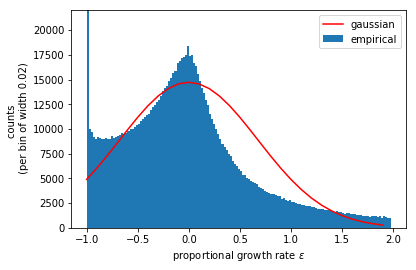

In [14]:

annual_pctdiff = levels.head(200000).pct_change(axis = 1).replace(np.inf, np.nan)
# annual_log = np.log10(levels.reindex(annual_logdiff.index))
bin_w = .02

# Assume gabaix sigma eps and plot
valid = annual_pctdiff.stack().loc[annual_pctdiff.stack() < 2]
s = valid.std()
cnt = len(valid)
x = np.arange(-1, 2, .1)

plt.plot(x, (bin_w * cnt)*gaussian(x, 0, s), c = 'r', label = 'gaussian')
h = plt.hist(annual_pctdiff.stack(), np.arange(-1, 2, bin_w), label = 'empirical')

plt.legend()

plt.xlabel('proportional growth rate '+r'$\epsilon$')
plt.ylabel('counts \n (per bin of width '+str(bin_w)+')')
plt.ylim(0, 22000)

plt.savefig('./../../../thesis_writing/figures/gabaix_growth_rates.png', dpi = 400)
plt.show()

### Growth rates defined as log diff

In [24]:
annual_logdiff = np.log10(levels).replace(-np.inf, np.nan).diff(axis = 1)
annual_log = np.log10(levels.reindex(annual_logdiff.index))

annual_logdiff = annual_logdiff.dropna(how = 'all').dropna(axis = 1, how = 'all')#.head(50000)

vals = np.reshape(annual_logdiff.values, (int(np.prod(annual_logdiff.shape)/2), 2))
growth_rates = pd.DataFrame(vals, columns = [0, 1], index = int(annual_logdiff.shape[1]/2)*list(annual_logdiff.index)).dropna()

sizes = pd.DataFrame(np.log10(levels.mean(1)), columns = ['log_size'])

In [17]:
growth_rates[0].std()

0.5028367947412729

#### One step and two step growth simulation

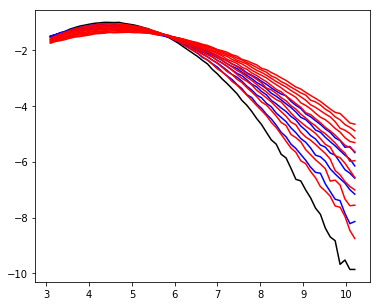

In [18]:
x = fit_data.log_VART

fig, axs = plt.subplots(1, figsize = (6, 5))

ax = axs

n = int(1e6)
x0 = np.random.normal(mu, sigma, n)
xs = x0

cnt, bns = np.histogram(x0, x)
cnt = cnt/cnt.sum()
ax.plot(x[:-1] + .115/2, np.log(cnt) + 2.2, c = 'k')


for s in range(5):
    synth_gr = growth_rates.sample(n, replace = True).values
    xs = xs + synth_gr[:, 0] + synth_gr[:, 1]

    cnt, bns = np.histogram(xs, x)
    cnt = cnt/cnt.sum()
    ax.plot(x[:-1] + .115/2, np.log(cnt) + 2.2, c = 'b')
    
xs = x0

for s in range(10):
    synth_gr = growth_rates.sample(n, replace = True).values
    xs = xs + synth_gr[:, 0]

    cnt, bns = np.histogram(xs, x)
    cnt = cnt/cnt.sum()
    ax.plot(x[:-1] + .115/2, np.log(cnt) + 2.2, c = 'r')


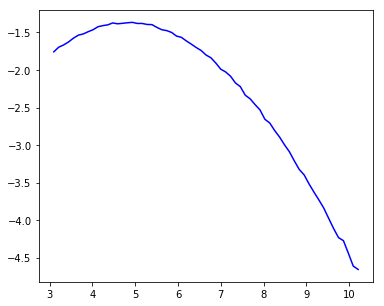

In [19]:
fig, axs = plt.subplots(1, figsize = (6, 5))
ax = axs
cnt, bns = np.histogram(xs, x)
cnt = cnt/cnt.sum()
ax.plot(x[:-1] + .115/2, np.log(cnt) + 2.2, c = 'b')
plt.show()

In [20]:
#### Distinguish growth rates of small vs large firms

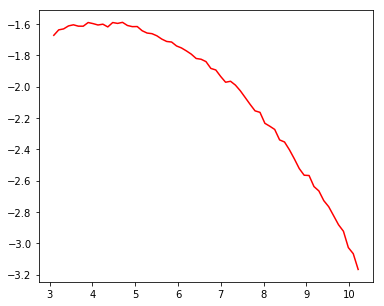

In [21]:
fig, axs = plt.subplots(1, figsize = (6, 5))
ax = axs
n = int(1e6)
x0 = np.random.normal(mu, sigma, n)
xs = x0
for s in range(25):
    q = np.quantile(x0, 1 - .158)
    q = 5.8
    xs1 = xs[xs < q]
    synth_gr = growth_rates.loc[sizes.loc[sizes.log_size < q].index].sample(len(xs1), replace = True).values
    xs1 = xs1 + synth_gr[:, 0] + synth_gr[:, 1]

    xs2 = xs[xs > q]
                                                           # Use the typical large firm depce
    synth_gr = growth_rates.loc[sizes.loc[sizes.log_size > 8].index].sample(len(xs2), replace = True).values
    xs2 = xs2 + synth_gr[:, 0] + synth_gr[:, 1]

    xs = np.append(xs1, xs2)
    
    cnt, bns = np.histogram(xs, x)
    cnt = cnt/cnt.sum()
# plot last
ax.plot(x[:-1] + .115/2, np.log(cnt) + 2.2, c = 'r')
plt.show()

In [ ]:
### Get N based on the deciles of the value dist: m_val = m_cnt + sigma

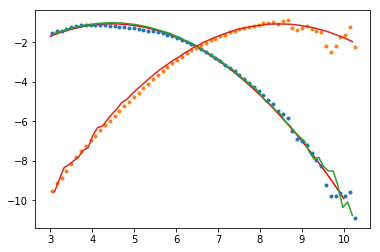

In [125]:
x = fit_data.log_VART
y = fit_data.counts
y2 = fit_data.value
z = np.polyfit(x, y, 2)
p = np.poly1d(z)

xp = np.linspace(3, 10, 70)
plt.plot(xp, p(xp), '-', c = 'r')
plt.plot(x, y, '.')
plt.plot(x, y2, '.')

sigma = 1/np.sqrt(-2*z[0])
mu = -z[1]/(2*z[0])

cnt, bns = np.histogram(np.random.normal(mu, sigma, 1000000), x)
cnt = cnt/cnt.sum()
plt.plot(x[:-1] + .115/2, np.log(cnt) + 2.2)

cnt, bns = np.histogram(np.random.normal(mu + (sigma**2)*np.log(10), sigma, 1000000), x)
cnt = cnt/cnt.sum()
plt.plot(x[:-1] + .115/2, np.log(cnt) + 2.2)

(3, 10)

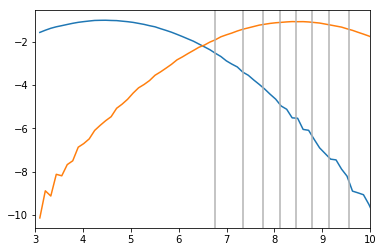

In [128]:
cnt, bns = np.histogram(np.random.normal(mu, sigma, 1000000), x)
cnt = cnt/cnt.sum()
plt.plot(x[:-1] + .115/2, np.log(cnt) + 2.2)

cnt, bns = np.histogram(np.random.normal(mu + (sigma**2)*np.log(10), sigma, 1000000), x)
cnt = cnt/cnt.sum()
plt.plot(x[:-1] + .115/2, np.log(cnt) + 2.2)

value_qs = []
for q in range(0, 110, 10):
    value_qs += [np.percentile(np.random.normal(mu + (sigma**2)*np.log(10), sigma, 1000000), q)]
    
    
for v in value_qs:
    plt.axvline(v, c = '.7')
plt.xlim(3, 10)

In [212]:
1/np.sqrt(cnt)

array([0.0010321 , 0.00620771, 0.01102033, 0.01721581, 0.02501564,
       0.03820804, 0.05415304, 0.08164966, 0.16012815, 0.5       ])

In [160]:
np.power(-np.power(10, z[1])/(z[0]-1), -1/(z[0]-1))

900.7069616646027

In [156]:
np.power(10, z[1])/(z[0]-1)

-2707451.7789549506

In [243]:
(sizes > value_qs[0]).sum()

log_size    169990
dtype: int64

In [209]:
z[0]

-1.1771463517566294

In [210]:
value_qs[1]

6.761137273357318